In [19]:
from collections import namedtuple

import pynput            as pyn
import numpy             as np
import matplotlib        as mpl
import matplotlib.pyplot as plt

from scipy import odr

In [20]:
reference_image = plt.imread("/Users/Gonzalo/github/CC/setup_monitor/reference.png")

In [21]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 10, 8

In [39]:
Position = namedtuple("Position", "x y")

class Cache:
    def __init__(self, value=None):
        self._value   = value
        self._updated = False

    @property
    def updated(self):
        return self._updated
    
    @property
    def value(self):
        return self._value

    def read(self):
        self._updated = False
        return self._value

    def write(self, *value):
        self._value   = value[0] if len(value) is 1 else value
        self._updated = True

def position_recorder():
    cache = Cache()
    def record_position(x, y, button, pressed):
        if button is pyn.mouse.Button.left and pressed:
            cache.write(x, y)
    return cache, record_position

In [77]:
def ask_for_points():
    cache, record_position = position_recorder()
    positions = dict()
    with pyn.mouse.Listener(on_click=record_position) as listener:
        for position in "top left.top right.bottom left.bottom right".split("."):
            print(f"Click on the {position} border of the image")
            while not cache.updated:
                time.sleep(.01)
            positions[position] = Position(*cache.read())
        for tick in range(0, 60, 10):
            print(f"Click on the number {tick}")
            while not cache.updated:
                time.sleep(.01)
            positions[tick] = Position(*cache.read())
    return positions


def perform_checks(positions):
    assert positions["top left" ].y < positions["bottom left" ].y
    assert positions["top left" ].y < positions["bottom right"].y
    assert positions["top right"].y < positions["bottom left" ].y
    assert positions["top right"].y < positions["bottom right"].y

    assert positions["top left"   ].x < positions["top right"   ].x
    assert positions["top left"   ].x < positions["bottom right"].x
    assert positions["bottom left"].x < positions["top right"   ].x
    assert positions["bottom left"].x < positions["bottom right"].x


def circle_implicit(params, xy):
    """ implicit definition of the circle """
    x0, y0, r = params
    x , y     = xy
    return (x - x0)**2 + (y - y0)**2 - r**2

def circle_y(x, params, sign=1):
    x0, y0, r = params
    return y0 + np.sqrt(r**2 - (x - x0)**2) * sign

def build_wheel(positions):
    ps = []
    xs = []
    ys = []
    for p, (x, y) in positions.items():
        if not isinstance(p, int): continue
        ps = np.append(ps, p)
        xs = np.append(xs, x)
        ys = np.append(ys, y)
    
    params0 = [np.max(xs), np.mean(ys), np.max(ys) - np.min(ys)]

    data   = odr.Data (np.row_stack([xs, ys]), y=1)
    model  = odr.Model(circle_implicit, implicit=True)
    cls    = odr.ODR  (data, model, params0)
    out    = cls.run()
    params = out.beta
    return (xs, ys, ps), params

def calibrate():
    plt.imshow(reference_image)
    plt.show()

    positions = ask_for_points()
    perform_checks(positions)
    (xs, ys, ps), params = build_wheel(positions)
    
    xdraw  = np.linspace(xs.min(), xs.max(), 1001)
    plt.imshow(reference_image)
    plt.scatter(xs, ys, color="k")
    plt.plot(xdraw, circle_y(xdraw, params, +1), "r-")
    plt.plot(xdraw, circle_y(xdraw, params, -1), "b-")

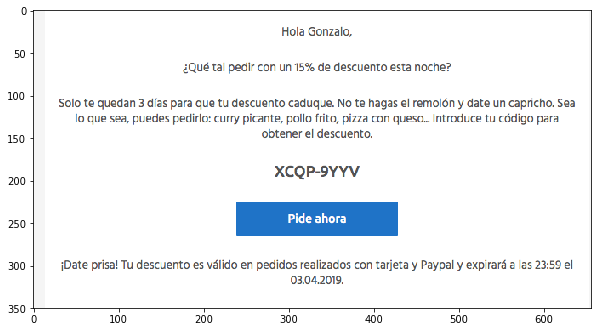

Click on the top left border of the image
Click on the top right border of the image
Click on the bottom left border of the image
Click on the bottom right border of the image
Click on the number 0
Click on the number 10
Click on the number 20
Click on the number 30
Click on the number 40
Click on the number 50


/Applications/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


In [78]:
calibrate()

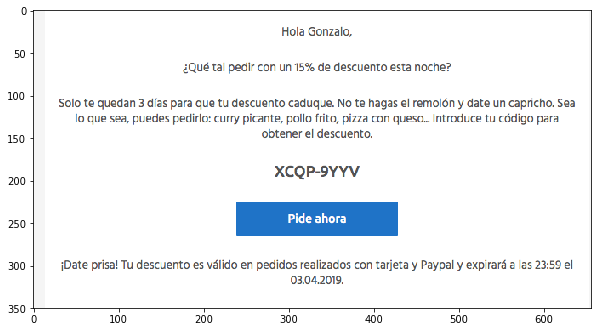

Click on the top left border of the image
Click on the top right border of the image
Click on the bottom left border of the image
Click on the bottom right border of the image
Click on the number 0
Click on the number 10
Click on the number 20
Click on the number 30
Click on the number 40
Click on the number 50


TypeError: 'dict' object is not callable

In [45]:
positions = calibrate()
perform_checks(positions)

(370.70703125, 505.06640625)
(711.1328125, 571.1875)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 799.99609375)
(1279.99609375, 799.99609375)
(970.5390625, 44.3359375)
(984.6640625, 652.7109375)
(284.43359375, 320.61328125)
(866.71875, 552.34765625)
(664.546875, 64.03515625)
(1136.6015625, 46.23828125)
(1137.640625, 308.52734375)
(1137.640625, 308.52734375)
(1137.640625, 308.52734375)
(1137.640625, 308.52734375)
(1137.640625, 308.52734375)
(685.1015625, 43.23046875)
(369.3125, 233.24609375)


KeyboardInterrupt: 

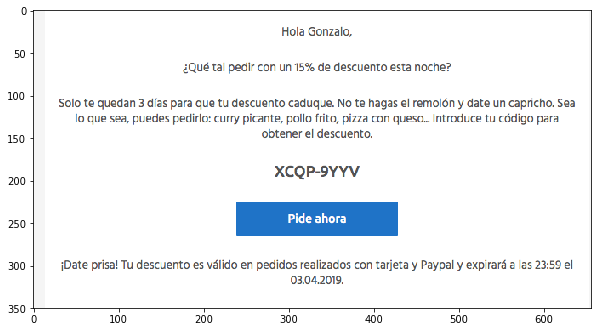

In [32]:
import time

plt.imshow(reference_image)
cache, record_position = position_recorder()
with pyn.mouse.Listener(on_click=record_position) as listener:
    while True:
        time.sleep(.01)
        if cache.updated:
            print(cache.read())
    